# Policy Function Iteration, Convergence Criterion, Solvers

Topics:
1. Policy Function Iteration
2. Root-finding with bisection
3. Hill-climbing algorithm

## Policy Function Iteration

In our dynamic programming problem one of the most expensive steps was finding the optimal consumption choice. But, once we find it, we only use the solution once,
$$
V_{n+1}(a) = u(c_n(a)) + \beta V_n((1+r)a + y - c_n(a)).
$$
Then in the next round we compute another policy.

Policy iteration is an improvement-step that repeatedly applies the solution $c_n$ in the Bellman equation before we step into another value function iteration. Denote $V_{n,m}$ the value function after $n$ value function iterations and $m$ policy function iterations. Then,
$$
V_{n,m+1}(a) = u(c_{n}(a)) + \beta V_{n,m}((1+r)a + y - c_n(a)).
$$

This can significantly speed up finding the solution. But there is a cost in that global convergence is no longer guaranteed.

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Converged after 18 iterations.


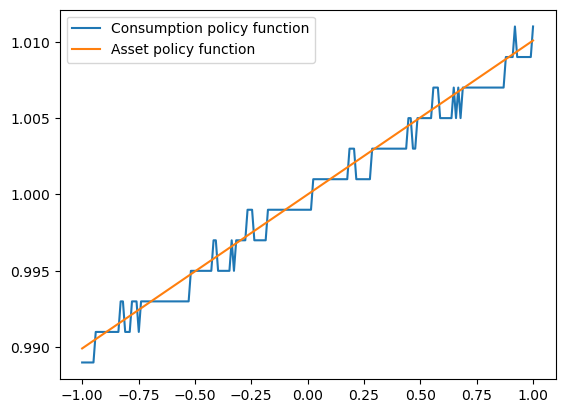

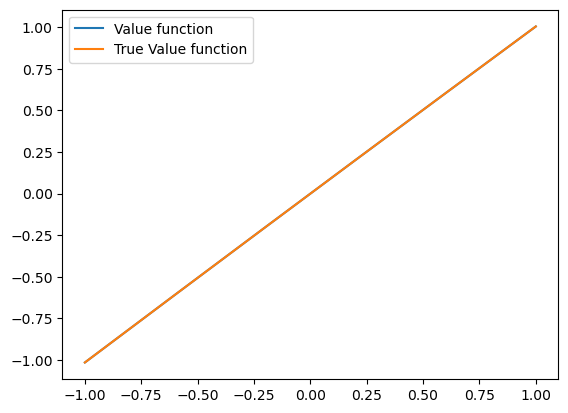

In [128]:
# same setup as before
max_iter = 2000
policy_iter = 100
tolerance = 1e-7
iteration = 0

# fix parameters beta, r, and y
beta = 0.99
r = (1/beta) - 1
y = 1
amin = -1
amax = 1
grid_size = 200

# define asset grid
a = np.linspace(amin, amax, grid_size)

# initial guess for the value function
v0 = np.linspace(1, 10, grid_size)

# define utility function --- makes it easy to change later
def utility(c):
    return np.log(c)

v_new = v0

# Howard iteration in value function consumption problem
while iteration < max_iter:
    v_old = v_new
    c_candidates = y + np.linspace(-0.5, 0.5, 500)
    a_prime_candidates = (1+r)*a[np.newaxis, :] + y - c_candidates[:, np.newaxis]
    f_interp = interp1d(a, v_old, kind='linear', bounds_error=False, fill_value=(-10000, 0))
    v_prime_candidates = f_interp(a_prime_candidates)
    utility_values = utility(c_candidates[:, np.newaxis]) + beta * v_prime_candidates
    c_index = np.argmax(utility_values, axis=0)
    c = c_candidates[c_index]
    v_new = np.max(utility_values, axis=0)

    # howard iteration
    for _ in range(policy_iter):
        a_prime = (1+r)*a + y - c
        f_interp = interp1d(a, v_new, kind='linear', bounds_error=False, fill_value=(-10000, 0))
        v_new = utility(c) + beta * f_interp(a_prime)

    if np.max(np.abs(v_new - v_old)) < tolerance:
        print(f'Converged after {iteration} iterations.')
        break
    iteration += 1

# plot consumption against true consumption function
plt.plot(a, c, label='Consumption policy function')
plt.plot(a, y + r * a, label='Asset policy function')
plt.legend()
plt.show()

# plot against true value function
plt.plot(a, v_new, label='Value function')
plt.plot(a, utility(y + r * a) / (1-beta), label='True Value function')
plt.legend()
plt.show()

Another form of policy function iteration iterates directly on the FOC. We know the Euler equation for our model is
\begin{align*}
u'(c(a)) = \beta(1+r)u'(c((1+r)a + y - c(a)))
\end{align*}

We can form a guess $c(a)$ and iterate on the FOC. However, unlike iterating on the value function we generally cannot guarantee convergence. (Why?)

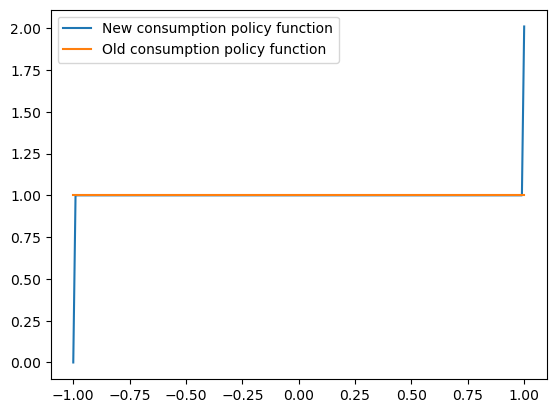

In [129]:
# define marginal utility function and inverse marginal utility function
def margutility(c):
    return 1 / c 

def invmargutility(u):
    return 1 / u 

# start with an intial guess for the consumption policy function
c_0 = y + np.zeros(a.shape)

# the implied next period assets are
aprime = (1 + r) * a + y - c_0

# interpolate c_0 to get cprime (note: different penalties for extrapolation)
f_interp = interp1d(a, c_0, kind='linear', bounds_error=False, fill_value=(0.0001,(1 + r) * amax + y))
cprime = f_interp(aprime)

# the new consumption policy function is
c_new = invmargutility( beta * (1 + r) * margutility(cprime) )

# plot c_new against c0
plt.plot(a, c_new, label='New consumption policy function')
plt.plot(a, c_0, label='Old consumption policy function')
plt.legend()
plt.show()

Now try this approach iterating until convergence. Plot against the true value function. What do you get and why?

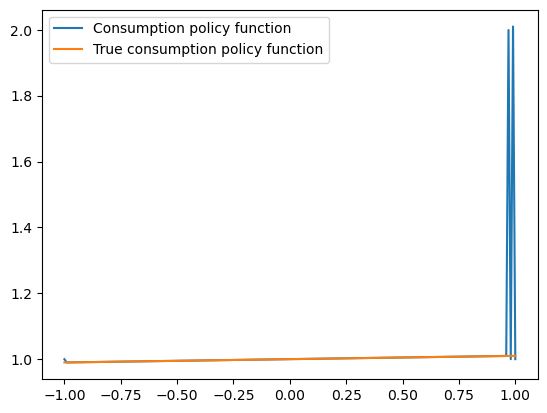

In [130]:
# iterate on the consumption policy function
c_new = y + np.zeros(a.shape)

iteration = 0
while iteration < max_iter:
    c_old = c_new
    aprime = (1 + r) * a + y - c_old
    f_interp = interp1d(a, c_old, kind='linear', bounds_error=False, fill_value=(0.0001,(1 + r) * amax + y))
    cprime = f_interp(aprime)
    c_new = invmargutility( beta * (1 + r) * margutility(cprime) )

    if np.max(np.abs(c_new - c_old)) < tolerance:
        print(f'Converged after {iteration} iterations.')
        break
    iteration += 1

# plot consumption against true consumption function
plt.plot(a, c_new, label='Consumption policy function')
plt.plot(a, y + r * a, label='True consumption policy function')
plt.legend()
plt.show()

Converged after 664 iterations.


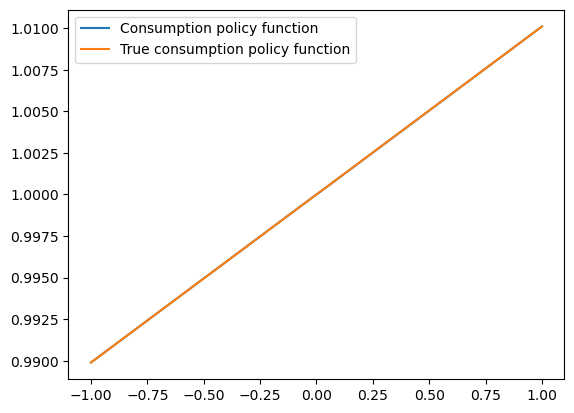

In [131]:
# Generally it makes more sense to iterate on the saving policy function because it is easier to stay in the state space
c_new = y + np.zeros(a.shape)
aprime_new = (1 + r) * a + y - c_new

iteration = 0
while iteration < max_iter:
    aprime = aprime_new
    f_interp = interp1d(a, aprime, kind='linear', bounds_error=False, fill_value=(amin, amax))
    aprimeprime = f_interp(aprime)
    cprime = (1 + r) * aprime + y - aprimeprime
    c_new = invmargutility( beta * (1 + r) * margutility(cprime) )

    aprime_new = (1 + r) * a + y - c_new

    if np.max(np.abs(aprime_new - aprime)) < tolerance:
        print(f'Converged after {iteration} iterations.')
        break
    iteration += 1

# plot consumption against true consumption function
plt.plot(a, c_new, label='Consumption policy function')
plt.plot(a, y + r * a, label='True consumption policy function')
plt.legend()
plt.show()

## Solvers

In macroeconomics we are often interested in solving for parameters that satisfy certain condition. E.g., starting from an aggregate supply of assets $A_{-1}=1$ we want to find the interest rate such that $A_t=1$ at all times. 

We can view this as market clearing problem. We know the asset supply is $A=1$ and we need to find the interest rate such that the asset demand is also 1. I.e., we are looking for the 0-solution to excess demand / supply.

This is a root-finding problem. A root-finding problem can be cast as finding the $x$ such that $f(x)=0$. This means we can use other mathematical tools to find a solution that might be more effective since convergence through iteration is not guaranteed.

The benchmark root-finding method for a continuous function is called bisection. Let $f$ be a continuous function defined on an interval $[a, b]$ and where $f(a)$ and $f(b)$ have opposite signs (the function may extend beyond $[a,b]$). In this case $a$ and $b$ are said to bracket a root since, by the intermediate value theorem, the continuous function f must have at least one root in the interval $(a, b)$.

The algorithm proceeds as follows:
1. Calculate c, the midpoint of the interval, $c = \frac{a + b}{2}$
2. Calculate the function value at the midpoint, $f(c)$.
3. If convergence is satisfactory (that is, $c - a$ is sufficiently small, or $|f(c)|$ is sufficiently small), return $c$ and stop iterating.
4. Examine the sign of $f(c)$ and replace either $(a, f(a))$ or $(b, f(b))$ with $(c, f(c))$ so that there is a zero crossing within the new interval. 

Write a function for the bisection algorithm. Then test it on $f(x) = 3x + 1$.

In [148]:
# bisection algorithm
def bisection(f, a, b, tol=1e-5, max_iter=1000):
    """
    Implements the bisection algorithm to find the root of a function f.

    Parameters
    ----------
    f : function
        The function for which to find the root. The function should take a
        single variable and return a single variable.
    a : scalar
        The left bound of the initial interval.
    b : scalar
        The right bound of the initial interval.
    tol : scalar
        The convergence tolerance.
    max_iter : scalar
        The maximum number of iterations.

    Returns
    -------
    x : scalar
        The root of the function.
    """

    # check whether the initial values are valid
    if f(a) * f(b) >= 0:
        raise ValueError("The function values at the bounds must have different signs.")

    # initialize the variables
    iteration = 0

    # iterate until the convergence tolerance is met
    while iteration < max_iter:
        x = (a + b) / 2

        if np.abs(f(x)) < tol:
            break
    
        if f(a) * f(x) < 0:
            b = x
        else:
            a = x
        
        iteration += 1

    return x

# define the function for which to find the root
def f(x):
    return 3*x - 1

# find the root of the function
root = bisection(f, 0, 1)

# print the root
print(root)

0.33333587646484375


Now lets apply this idea to our consumption problem. We first plot the excess demand function. Then we use bisection to find the root.



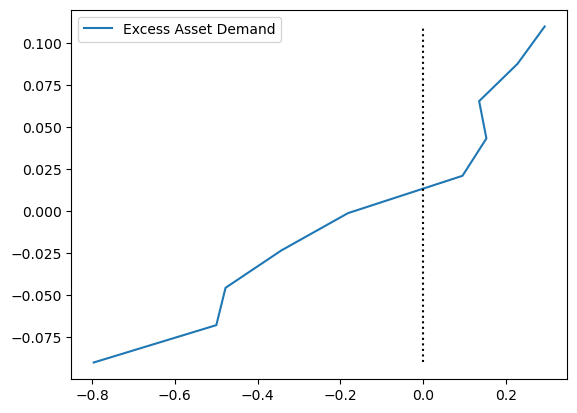

In [152]:
def excess_demand(r):
    c_new = y + np.zeros(a.shape)
    aprime_new = (1 + r) * a + y - c_new

    iteration = 0
    while iteration < max_iter:
        aprime = aprime_new
        f_interp = interp1d(a, aprime, kind='linear', bounds_error=False, fill_value=(amin, amax))
        aprimeprime = f_interp(aprime)
        cprime = (1 + r) * aprime + y - aprimeprime
        c_new = invmargutility( beta * (1 + r) * margutility(cprime) )

        aprime_new = (1 + r) * a + y - c_new

        if np.max(np.abs(aprime_new - aprime)) < tolerance:
            print(f'Converged after {iteration} iterations.')
            break
        iteration += 1

    # given a = A, the new choice of aprime is
    Aprime = f_interp(A)

    return Aprime - A

# plot consumption against true consumption function
A = 0.5
r_candidates =  (1/beta) - 1 + np.linspace(-0.1, 0.1, 10)
excess_demand_values = np.zeros(10)
for i, r in enumerate(r_candidates):
    excess_demand_values[i] = excess_demand(r)

plt.plot(excess_demand_values, r_candidates, label=f'Excess Asset Demand')
plt.plot(np.zeros_like(r_candidates), r_candidates, 'k:')
plt.legend()
plt.show()

In [153]:
# find the root of the function
rstar = bisection(excess_demand, 0, 0.025)

print(rstar, (1/beta) - 1)

Converged after 665 iterations.
0.01010093688964844 0.010101010101010166


The other main way to solve this problem is use the Newton-Raphson method. The idea comes from the Taylor approximation
$$
f(x+\delta) = f(x) + \delta f'(x) + h.o.t.
$$
Starting at a given $x$ we are looking for $f(x+\delta) = 0$. From the above we get
$$
\delta = - \frac{f(x)}{f'(x)}
$$
This suggests iteratively updating $x$ using
$$
x_{n+1} = x_n + \delta = x_n - \frac{f(x_n)}{f'(x_n)}
$$
until we converge.

The main tradeoff with bisection is that this algorithm may fail to converge and it requires us to compute a derivative. But it can be substantially faster in well-behaved problems.